# Information Elements Categorical Embeddings

## Libraries and Configurations

Import configuration files

In [111]:
from configparser import ConfigParser

config = ConfigParser()
config.read("../config.ini")

['../config.ini']

Import **data libraries**

In [112]:
import pandas as pd

Import **ML libraries**

In [113]:
from sklearn import preprocessing
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models

Import **other libraries**

In [114]:
import numpy as np

from rich.progress import Progress
from rich import traceback

traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x10e990c50>>

Custom helper scripts

In [115]:
%cd ..
from scripts import plotHelper, encodingHelper
%cd data_exploration_cleaning

/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/notebooks
/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/notebooks/data_exploration_cleaning


## Import Data

In [116]:
# Combined dataframe
combined_df_csv = config["DEFAULT"]["interim_path"] + "balanced_df_raw.csv"

In [117]:
df = pd.read_csv(combined_df_csv, index_col=0)

Keeping only categorical columns to be encoded

In [118]:
df = df[["HT Capabilities", "Extended Capabilities", "Vendor Specific Tags", "Label"]]

In [119]:
df

,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Label
0,2d001bff00000000000000000000000000000000000000...,80000000040000020,NaN,iPhone12Pro_C
1,2d001bff00000000000000000000000000000000000000...,80000000040000020,NaN,iPhone12Pro_C
2,2d001bff00000000000000000000000000000000000000...,80000000040000020,NaN,iPhone12Pro_C
3,2d001bff00000000000000000000000000000000000000...,80000000040000020,NaN,iPhone12Pro_C
4,2d001bff00000000000000000000000000000000000000...,80000000040000020,NaN,iPhone12Pro_C
...,...,...,...,...
13939,2d0113ff00000000000000000000000000000000000000...,04000a02004000408001,0050f208002400,XiaomiRedmiNote7_S
13940,2d0113ff00000000000000000000000000000000000000...,04000a02004000408001,0050f208002400,XiaomiRedmiNote7_S
13941,2d0113ff00000000000000000000000000000000000000...,04000a02004000408001,0050f208002400,XiaomiRedmiNote7_S
13942,2d0113ff00000000000000000000000000000000000000...,04000a02004000408001,0050f208002400,XiaomiRedmiNote7_S


In [120]:
df = df.rename(
    columns={
        "HT Capabilities": "HT_Capabilities",
        "Extended Capabilities": "Extended_Capabilities",
        "Vendor Specific Tags": "Vendor_Specific_Tags",
    }
)

In [121]:
label_encoder = preprocessing.LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Label"])

Selecting categorical features

In [122]:
features = [f for f in df.columns if f != "Label"]

In [123]:
features

['HT_Capabilities', 'Extended_Capabilities', 'Vendor_Specific_Tags']

## Label Encoding

In [124]:
for feat in features:
    encoder = preprocessing.LabelEncoder()
    df.loc[:, feat] = encoder.fit_transform(df[feat].astype(str).fillna("-1").values)

In [125]:
df

,HT_Capabilities,Extended_Capabilities,Vendor_Specific_Tags,Label
0,6,17,62,23
1,6,17,62,23
2,6,17,62,23
3,6,17,62,23
4,6,17,62,23
...,...,...,...,...
13939,8,7,25,17
13940,8,7,25,17
13941,8,7,25,17
13942,8,7,25,17


In [126]:
df

,HT_Capabilities,Extended_Capabilities,Vendor_Specific_Tags,Label
0,6,17,62,23
1,6,17,62,23
2,6,17,62,23
3,6,17,62,23
4,6,17,62,23
...,...,...,...,...
13939,8,7,25,17
13940,8,7,25,17
13941,8,7,25,17
13942,8,7,25,17


## Entity Embedding

Splitting `df` into train and test set

In [127]:
X = df.drop(columns=["Label"])
y = df["Label"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [128]:
X_train.shape, X_test.shape

((28836, 3), (7210, 3))

In [129]:
def get_model(df: pd.DataFrame, categorical_columns: str) -> models.Model:
    inputs = []
    outputs = []

    for c in categorical_columns:
        num_unique_values = int(df[c].nunique())
        # embed_dim = int(min(np.ceil((num_unique_values) / 2), 50))
        embed_dim = 3
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
        out = layers.Reshape(target_shape=(embed_dim,))(out)
        inputs.append(inp)
        outputs.append(out)

    x = layers.Concatenate()(outputs)
    x = layers.Dense(300, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    y = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=inputs, outputs=y)

    return model

In [130]:
model = get_model(X_train, features)
model.compile(
    loss="binary_crossentropy", optimizer=optimizers.Adam(0.001), metrics=["mae"]
)

In [131]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 HT_Capabilities (Embedding  (None, 1, 3)                 72        ['input_10[0][0]']            
 )                                                                                          

In [132]:
x = [X_train.loc[:, f].values for f in features]

x = [np.asarray(x[i]).astype("float32") for i in range(len(x))]

x

[array([13., 19., 22., ..., 12., 11., 13.], dtype=float32),
 array([19.,  5., 25., ..., 23., 19., 19.], dtype=float32),
 array([62., 18., 26., ...,  1., 62., 62.], dtype=float32)]

In [133]:
xt = [X_test.loc[:, f].values for f in features]

xt = [np.asarray(xt[i]).astype("float32") for i in range(len(xt))]

xt

[array([ 4.,  8., 12., ..., 13., 17., 11.], dtype=float32),
 array([11.,  7., 23., ..., 19.,  0., 19.], dtype=float32),
 array([62., 25.,  1., ..., 62.,  3., 62.], dtype=float32)]

In [134]:
ie_fit = model.fit(
    x,
    y_train,
    epochs=5,
    batch_size=32,
    validation_data=(xt, y_test),
)

Epoch 1/5


902/902 [==============================] - 7s 5ms/step - loss: -4317668.5000 - mae: 14.0417 - val_loss: -21794854.0000 - val_mae: 14.1226
Epoch 2/5
902/902 [==============================] - 3s 4ms/step - loss: -117820504.0000 - mae: 14.0289 - val_loss: -286552032.0000 - val_mae: 14.1226
Epoch 3/5
902/902 [==============================] - 2s 3ms/step - loss: -653507584.0000 - mae: 14.0289 - val_loss: -1164035072.0000 - val_mae: 14.1226
Epoch 4/5
902/902 [==============================] - 3s 3ms/step - loss: -1973326208.0000 - mae: 14.0289 - val_loss: -3008684288.0000 - val_mae: 14.1226
Epoch 5/5
902/902 [==============================] - 3s 3ms/step - loss: -4421915648.0000 - mae: 14.0289 - val_loss: -6164849664.0000 - val_mae: 14.1226


In [135]:
model.save(config["DEFAULT"]["models_path"] + "IE_embeddings.h5")

/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [136]:
import matplotlib.pyplot as plt

In [137]:
ie_fit.history

{'loss': [-4317668.5,
  -117820504.0,
  -653507584.0,
  -1973326208.0,
  -4421915648.0],
 'mae': [14.04166030883789,
  14.028887748718262,
  14.028887748718262,
  14.028887748718262,
  14.028887748718262],
 'val_loss': [-21794854.0,
  -286552032.0,
  -1164035072.0,
  -3008684288.0,
  -6164849664.0],
 'val_mae': [14.122607231140137,
  14.122607231140137,
  14.122607231140137,
  14.122607231140137,
  14.122607231140137]}

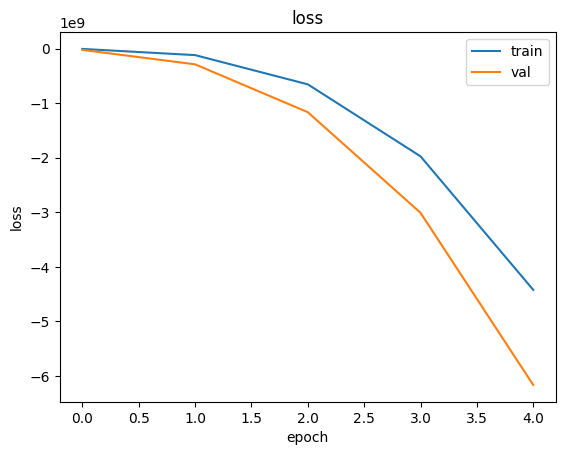

In [138]:
# summarize history for loss
plt.plot(ie_fit.history["loss"])
plt.plot(ie_fit.history["val_loss"])
plt.title("loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")

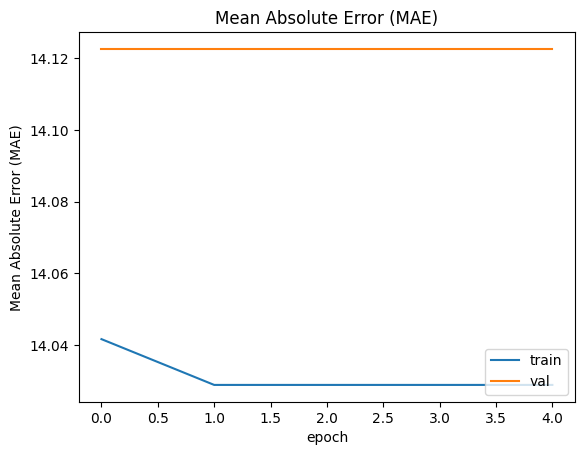

In [139]:
# summarize history for mae
plt.plot(ie_fit.history["mae"])
plt.plot(ie_fit.history["val_mae"])
plt.title("Mean Absolute Error (MAE)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="lower right")
plt.show()

In [140]:
import seaborn as sns

226/226 [==============================] - 0s 1ms/step


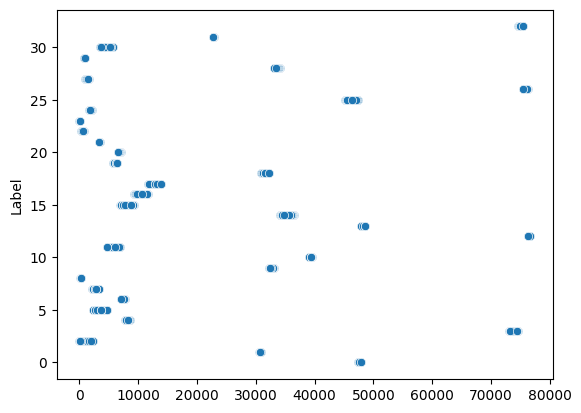

In [141]:
# Make prediction
y_test_predict = model.predict(xt)

# Change the predictions from 2-d to 1-d
y_test_predict = y_test_predict.flatten()

# Visualization
ax = sns.scatterplot(y_test)

In [142]:
# Import library
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

# Mean squared error
MSE = mean_squared_error(y_test, y_test_predict)
# Root mean squared error
RMSE = np.sqrt(MSE)
# Mean absolute error
MAE = mean_absolute_error(y_test, y_test_predict)

R2 = r2_score(y_test, y_test_predict)
MAPE = mean_absolute_percentage_error(y_test, y_test_predict)

print(f"The MSE for the model is {MSE:.2f}")
print(f"The RMSE for the model is {RMSE:.2f}.")
print(f"The MAE for the model is {MAE:.2f}.")
print(f"The R-squared for the model is {R2:.2f}.")
print(f"The MAPE for the model is {MAPE:.2f}.")

The MSE for the model is 278.55
The RMSE for the model is 16.69.
The MAE for the model is 14.12.
The R-squared for the model is -2.49.
The MAPE for the model is 61838607920899.50.


In [143]:
model.get_layer("Vendor_Specific_Tags").get_weights()

[array([[ 5.18313265e+00, -5.15447187e+00, -5.16146517e+00],
        [ 6.57904243e+00, -6.47832012e+00, -6.58623457e+00],
        [ 1.22870624e+00, -1.19358015e+00, -1.16048694e+00],
        [ 7.29449320e+00, -7.26394510e+00, -7.27845764e+00],
        [ 4.08811140e+00, -4.08064747e+00, -4.09502506e+00],
        [ 6.12620068e+00, -6.11948538e+00, -6.18024635e+00],
        [ 2.18274212e+00, -2.22761703e+00, -2.20659828e+00],
        [ 1.26304150e+00, -1.30896521e+00, -1.35236323e+00],
        [ 1.19741046e+00, -1.20125997e+00, -1.24298584e+00],
        [ 7.54500687e-01, -7.56005466e-01, -8.10482562e-01],
        [ 2.50306934e-01, -2.58525491e-01, -2.40427122e-01],
        [ 4.63669586e+00, -4.61801386e+00, -4.62241888e+00],
        [ 1.44965482e+00, -1.53180003e+00, -1.47941172e+00],
        [ 3.69408727e-01, -3.72106731e-01, -4.07116413e-01],
        [ 2.28282750e-01, -2.28107110e-01, -2.35668033e-01],
        [ 8.79006803e-01, -8.47002447e-01, -9.20449317e-01],
        [ 1.30671990e+00

In [144]:
# Get weights from the embedding layer
cat_emb_df = pd.DataFrame(
    model.get_layer("Vendor_Specific_Tags").get_weights()[0]
).reset_index()

# Add prefix to the embedding names
cat_emb_df = cat_emb_df.add_prefix("Vendor_Specific_Tags_")

# Take a look at the data
cat_emb_df

,Vendor_Specific_Tags_index,Vendor_Specific_Tags_0,Vendor_Specific_Tags_1,Vendor_Specific_Tags_2
0,0,5.183133,-5.154472,-5.161465
1,1,6.579042,-6.478320,-6.586235
2,2,1.228706,-1.193580,-1.160487
3,3,7.294493,-7.263945,-7.278458
4,4,4.088111,-4.080647,-4.095025
...,...,...,...,...
59,59,-2.887947,2.854671,2.851262
60,60,-0.017124,0.004495,0.002696
61,61,0.085145,-0.130432,-0.174668
62,62,7.948878,-8.001369,-7.975625
